Notes on Dec 6:
For Enbrel, the specs may only contain text contents,specs convertion function will cause error.
Solution: consider first limiting to quantitative data and then converting the specs.

In [1]:
import os

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
from APRGenerator import APR_analytical_pipeline as apr

In [5]:
program="Aranesp"
file_path="query-Aranesp-APPX-OCT2.csv"

In [6]:
df=pd.read_csv(file_path,index_col=False)

In [7]:
pipeline=apr(program, file_path)

In [8]:
#delete the empty rows at the end of the file
df=df.dropna(how="all")

In the next APR session-
    if lots excluded from DME, no need to add product-specific operations as below;
    if lots included in the ADDM but wont be included for ppk, modify the cell below to manually exclude lots.

In [9]:
####product specific operations:
##batch number is string if df read from csv
#print len before and after


df=df[~((df["batch number"]=="10390991")&(df["parameter name"]=="Immunoassay"))]
#need to re_index the df if any records are deleted/added. Otherwise the length of subsetting conditions are probelmatic 
df=df.reset_index(drop=True)

In [10]:
df=pipeline.df_colname_unify(df)
# make modification on the original dataset, update the df outside the class 

In [11]:
df=pipeline.specs_num_conversion(df)

In [12]:
quan_list=pipeline.quanti_quali_namelists(df)[0]

In [13]:
#work only on the quantitative dataset after this 
df_quan=df[df["parameter name"].isin(quan_list)].copy()

In [14]:
para_unit_pair_df=pipeline.para_unit_combi_df(df_quan,grouping_list=["parameter name","unit procedure"])

In [24]:
df_quan=df_quan.sort_values(by=["parameter name","unit procedure","parameter date"])
#reset index after subsetting; otherwise the add_spec does not work
df_quan=df_quan.reset_index(drop=True)

In [25]:
df_quan=pipeline.spec_correction_rawset(df_quan)
#no return, make modification on df_quan, populate the specs of the last cells for each group
######CHECK THIS!!!!!!!!!!!!!!!!!!

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [27]:
df_quan=pipeline.add_specside(df_quan)
df_quan=pipeline.add_clside(df_quan)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [33]:
OOS_list=pipeline.find_oos_index(df_quan)
OOT_list=pipeline.find_oot_index(df_quan)

In [34]:
OOST_list=list(set(OOS_list+OOT_list))

In [35]:
df_quan_OOS=df_quan.loc[OOS_list]
#df_quan_OOT=df_quan.loc[OOT_list]
#df_quan_no_OOST=df_quan.loc[df_quan.index.difference(OOST_list)]
df_quan_no_OOS=df_quan.loc[df_quan.index.difference(OOS_list)]
#edit this part, output dataset based on your need
#df_quan_no_OOS.to_csv(program+"_quantitative_no_OOS.csv",index=False)

sum((df_quan_no_OOS[(df_quan_no_OOS["parameter name"]=="Immunoassay")&(df_quan_no_OOS["unit procedure"]\
                        =="PRJU:APR14-DP-ADL")].index).isin(OOT_list))

In [255]:
len(df_quan_no_OOS[(df_quan_no_OOS["parameter name"]=="Immunoassay")&(df_quan_no_OOS["unit procedure"]\
                        =="PRJU:APR14-DP-ADL")])

103

In [56]:
summary_df=pipeline.aggre_summary_df_generator(df_quan,"",min_size=30)
summary_df_no_OOS.reset_index(inplace=True)  
summary_df_no_OOS=pipeline.aggre_summary_df_generator(df_quan_no_OOS,"_no_OOS",min_size=20)
summary_df_no_OOS.reset_index(inplace=True)  
#turn the multi index into columns for the convinience of merging later

In [26]:
pipeline.summary_print(summary_df, purpose="Report",input_type="")
pipeline.summary_print(summary_df_no_OOS, purpose="Report",input_type="_no_OOS")

In [27]:
pipeline.summary_print(summary_df, purpose="R_pearson",input_type="")
pipeline.summary_print(summary_df_no_OOS, purpose="R_pearson",input_type="_no_OOS")

##### ---------------Send the output summary tables to Pearson function in R

In [43]:
summary_df_pearson=pd.read_csv(program+"_summary_stats_pearson.csv",index_col=None)
summary_df_no_OOS_pearson=pd.read_csv(program+"_summary_stats_no_OOS_pearson.csv",index_col=None)

FileNotFoundError: File b'Aranesp_summary_stats_pearson.csv' does not exist

In [53]:
#column name????
#The merged table with 4 ppks
summary_df_merged=summary_df_pearson.merge(summary_df_no_OOS_pearson,on=["unit procedure","parameter name"])

In [54]:
#can vary the threshold. Using 0.95 now bc of rounding
false_pos=summary_df_merged[(summary_df_merged["Ppk"]<0.95)&(summary_df_merged["pearson Ppk_no_OOS"]>=0.95)]
false_neg=summary_df_merged[(summary_df_merged["Ppk"]>=0.95)&(summary_df_merged["pearson Ppk_no_OOS"]<=0.95)]

In [55]:
false_pos.to_csv(program+"_false_pos.csv", index=False)
false_neg.to_csv(program+"_false_neg.csv", index=False)

In [69]:
#make directories for each parameter under false pos and false neg
#no space allowed in the folder name(check this out)
#The two lines below can not be combine to a single cell???

In [61]:
mkdir false_pos

In [65]:
mkdir false_neg

In [66]:
current_path=os.getcwd()

In [68]:
pipeline.JMP_single_para_subset_generator(false_pos, df_quan_no_OOS, folder_path=current_path+"/false_pos")
pipeline.JMP_single_para_subset_generator(false_neg, df_quan_no_OOS, folder_path=current_path+"/false_neg")

### -------------  Generate subsets for parameters that did not pass normality check

In [ ]:
mkdir non_normal

In [ ]:
replace $$ with a summary table only containing parameters with small shapiro values

In [ ]:
pipeline.JMP_single_para_subset_generator($$, df_quan_no_OOS, folder_path=current_path+"/non_normal")

In [226]:
pipeline.qqplot_screening_shapiro(program,shapiro_alpha=0.01,df_quan_no_OOS,summary_df_no_OOS)

SyntaxError: positional argument follows keyword argument (<ipython-input-226-0b64f317247e>, line 1)

In [115]:
#Nov 16: attempt to regenerate SAS output for the immunoassay pmafs
df_quan_no_OOST=df_quan.loc[df_quan.index.difference(OOST_list)]

df_quan_no_OOST[(df_quan_no_OOST["parameter name"]=="Immunoassay")&\
               (df_quan_no_OOST["unit procedure"].isin(["PRJU:APR1-DP-ADL","PRJU:APR14-DP-ADL"]))].to_csv(\
                                                                "aranesp_immu_two_pmafs_Nov16.csv",index=False)

In [258]:
df_quan_no_OOST[(df_quan_no_OOST["parameter name"]=="CHO Proteins Immunoassay")&\
               (df_quan_no_OOST["unit procedure"]=="PRJU:APR6-DS-AML")].to_csv(\
                                                                "aranesp_choimmu_pmaf_Nov30.csv",index=False)

In [112]:
ar=pd.read_csv("Aranesp_quantitative_no_OOS.csv",index_col=False)

pmafs=pd.read_csv("aranesp_pmaf_summary.csv",index_col=False)

aranesp_pmaf_raw=pd.merge(ar,pmafs[["parameter name","unit procedure"]])

aranesp_pmaf_raw.to_csv("aranesp_pmaf_appx_Nov2.csv",index=False)

pmaf_no_OOS=aranesp.aggre_summary_df_generator(aranesp_pmaf_raw,"_no_OOS",min_size=11)

In [68]:
import matplotlib.pyplot as plt  
%matplotlib inline

In [73]:
from scipy import stats

In [ ]:
stats.probplot(x, plot=plt)

In [178]:
ss=df_quan_summary[(df_quan_summary["shapiro"]<0.05)&(~summary_df_no_OOS["Ppk_no_OOS"].isin(["NA1","NA2","NA3"]))&(df_quan_summary["N"]>=30)]\
[["parameter name","unit procedure"]].drop_duplicates()

### all plots overlapped together when using groupby
df_quan_summary[df_quan_summary["kurtosis"]>2].groupby(["parameter name","unit procedure"])\
["value_num(recorded/full precision)"].apply(stats.probplot,plot=plt);

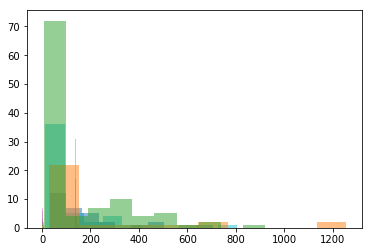

In [71]:
df_quan_summary[df_quan_summary["kurtosis"]>2].groupby(["parameter name","unit procedure"])\
["value_num(recorded/full precision)"].apply(plt.hist,alpha=0.5);

In [56]:
pd.read_csv("Aranesp_summary_stats_Report.csv",index_col=False)

,parameter name,unit procedure,N,mean,median,STD,variance,UAL,LAL,spec status,Ppk,skewness,kurtosis,CV,shapiro,KS
0,Chloride,IEDL:ADL9-DP-ADL,50,138.662200,138.48500,1.696981,2.879744e+00,170.0,110.0,0.0,5.6300379628300385,1.105692,3.662593,1.223824,2.289855e-03,0.000000e+00
1,Immunoassay,IEDL:ADL9-DP-ADL,57,1.031193,1.02350,0.053303,2.841241e-03,12.0,8.0,0.0,-43.579593254248856,0.331360,-0.327343,5.169090,7.188891e-01,0.000000e+00
2,In vitro bioassay,IEDL:ADL9-DP-ADL,50,104.400000,104.50000,6.077728,3.693878e+01,123.0,78.0,0.0,1.0201180735473223,-0.041020,1.787548,5.821578,8.635213e-02,0.000000e+00
3,Methionine Oxidation,IEDL:ADL9-DP-ADL,50,1.321600,1.32500,0.147196,2.166678e-02,4.0,.,1.0,6.065366381695688,-0.067031,-0.043242,11.137741,9.741972e-01,0.000000e+00
4,Phosphate,IEDL:ADL9-DP-ADL,50,19.904980,19.88550,0.265579,7.053206e-02,24.0,16.0,0.0,4.901220852057552,0.299120,0.480663,1.334233,6.419759e-01,0.000000e+00
5,Polysorbate 80,IEDL:ADL9-DP-ADL,57,0.004544,0.00450,0.000348,1.210777e-07,7.0,3.0,0.0,-2869.522532883776,0.070300,-0.644668,7.657855,3.491033e-01,8.637535e-14
6,SE-HPLC,IEDL:ADL9-DP-ADL,50,99.972880,99.97300,0.002819,7.944490e-06,.,995.0,-1.0,-105847.82404077121,-0.134594,0.368606,0.002819,2.752670e-01,0.000000e+00
7,Subvisible Particles >= 10 um,IEDL:ADL9-DP-ADL,50,109.054000,42.81000,151.458606,2.293971e+04,6000.0,.,1.0,12.964919698469018,2.959013,10.058229,138.884045,2.261463e-10,0.000000e+00
8,Subvisible Particles >= 25 um,IEDL:ADL9-DP-ADL,50,1.175400,0.37000,1.820657,3.314793e+00,600.0,.,1.0,109.63524510553805,2.902401,9.641608,154.896819,3.174999e-10,1.106670e-12
9,Volume (0.3 mL Syringe),IEDL:ADL9-DP-ADL,15,0.332540,0.33250,0.002326,5.412571e-06,.,3.0,-1.0,NA1,0.669534,0.049823,0.699613,3.923467e-01,2.825563e-06


In [37]:
from scipy.stats import kstest

In [50]:
kstest(np.random.normal(size=30),"norm")

KstestResult(statistic=0.21445620665509313, pvalue=0.10874168997828448)

In [260]:
aa=pd.read_csv("Aranesp_quantitative_no_OOS.csv")

In [262]:
ss=pd.read_csv("Aranesp_summary_stats_no_OOS.csv")

In [266]:
def ppk_CI(df):
    df["Ppk_Upper"]=df["Ppk_no_OOS"]*(1+1.96*np.sqrt(1/(9*df["N"]**2)+1/(2*(df["N"]-1))))
    df["Ppk_Lower"]=df["Ppk_no_OOS"]*(1-1.96*np.sqrt(1/(9*df["N"]**2)+1/(2*(df["N"]-1))))

In [267]:
ppk_CI(ss)

In [268]:
ss

,parameter name,unit procedure,N,mean,median,STD,variance,UAL,LAL,spec status,Ppk_no_OOS,skewness,kurtosis,CV,shapiro,KS,Ppk_Upper,Ppk_Lower
0,Chloride,IEDL:ADL9-DP-ADL,50,138.662200,138.485000,1.696981,2.879744e+00,170.0,110.0,0,5.630038,1.105692,3.662593,1.223824,2.289855e-03,0.000000e+00,6.747154,4.512922
1,Immunoassay,IEDL:ADL9-DP-ADL,57,1.031193,1.023500,0.053303,2.841241e-03,1.2,0.8,0,1.055639,0.331360,-0.327343,5.169090,7.188891e-01,0.000000e+00,1.251520,0.859757
2,In vitro bioassay,IEDL:ADL9-DP-ADL,50,104.400000,104.500000,6.077728,3.693878e+01,123.0,78.0,0,1.020118,-0.041020,1.787548,5.821578,8.635213e-02,0.000000e+00,1.222531,0.817706
3,Methionine Oxidation,IEDL:ADL9-DP-ADL,50,1.321600,1.325000,0.147196,2.166678e-02,4.0,.,1,6.065366,-0.067031,-0.043242,11.137741,9.741972e-01,0.000000e+00,7.268860,4.861873
4,Phosphate,IEDL:ADL9-DP-ADL,50,19.904980,19.885500,0.265579,7.053206e-02,24.0,16.0,0,4.901221,0.299120,0.480663,1.334233,6.419759e-01,0.000000e+00,5.873724,3.928718
5,Polysorbate 80,IEDL:ADL9-DP-ADL,57,0.004544,0.004500,0.000348,1.210777e-07,0.007,0.003,0,1.478953,0.070300,-0.644668,7.657855,3.491033e-01,8.637535e-14,1.753383,1.204523
6,SE-HPLC,IEDL:ADL9-DP-ADL,50,99.972880,99.973000,0.002819,7.944490e-06,.,99.5,-1,55.923802,-0.134594,0.368606,0.002819,2.752670e-01,0.000000e+00,67.020236,44.827367
7,Subvisible Particles >= 10 um,IEDL:ADL9-DP-ADL,50,109.054000,42.810000,151.458606,2.293971e+04,6000.0,.,1,12.964920,2.959013,10.058229,138.884045,2.261463e-10,0.000000e+00,15.537427,10.392412
8,Subvisible Particles >= 25 um,IEDL:ADL9-DP-ADL,50,1.175400,0.370000,1.820657,3.314793e+00,600.0,.,1,109.635245,2.902401,9.641608,154.896819,3.174999e-10,1.106670e-12,131.389137,87.881353
9,pH,IEDL:ADL9-DP-ADL,43,6.182093,6.180000,0.024354,5.931340e-04,6.4,6.0,0,2.492273,-0.068828,-0.301466,0.393950,5.954637e-01,0.000000e+00,3.026598,1.957948
